#### Импорты

In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

#### Теория

Закон радиоактивного распада:  
$N = N_0 e^{-\lambda t} (1)$  
  
Скорость счёта детектора:  
$\frac{\triangle N}{\triangle t} = \triangle \sigma(E_\nu) j \ (2)$  
  
<a href="http://nuclphys.sinp.msu.ru/spargalka/009.htm" target="_blank">Отсюда</a> взята информация о сечении взаимодействия антинейтрино и протона (верно для низких энергий)
     
Реакция обратного $\beta$-захвата:  
$\bar{\nu_e} + p \to e^+ + n$  
  
Зависимость сечения от энергии:  
$\sigma(\bar{\nu_e}p) \approx 10^{-43} см^2 \ p_e E_e E_\nu^{−0.07056+0.02018lnE_\nu−0.001953 ln^3E_\nu}, \ \ E_e = E_\nu - \triangle, \\
где \ \triangle = m_n − m_p \approx 1.293 \ МэВ; \\
E^2 = p^2 + m^2 \ (c=1) \ \Rightarrow p_e = \sqrt{E_e^2 - m_e^2} = \sqrt{(E_\nu - \triangle)^2 - m_e^2}$  
<a href="https://pdg.lbl.gov/2023/tables/contents_tables.html" target="_blank">Массы и вообще всё</a>  
  
$Периоды \ полураспада: \\
U^{235}:\ 1.592(2)*10^{5} \ лет \\
U^{238}:\ 4.468(3)*10^{9} \ лет \\
Pu^{239}:\ 24100 лет\\
Pu^{241}:\ 14.4 лет$


#### Спектры

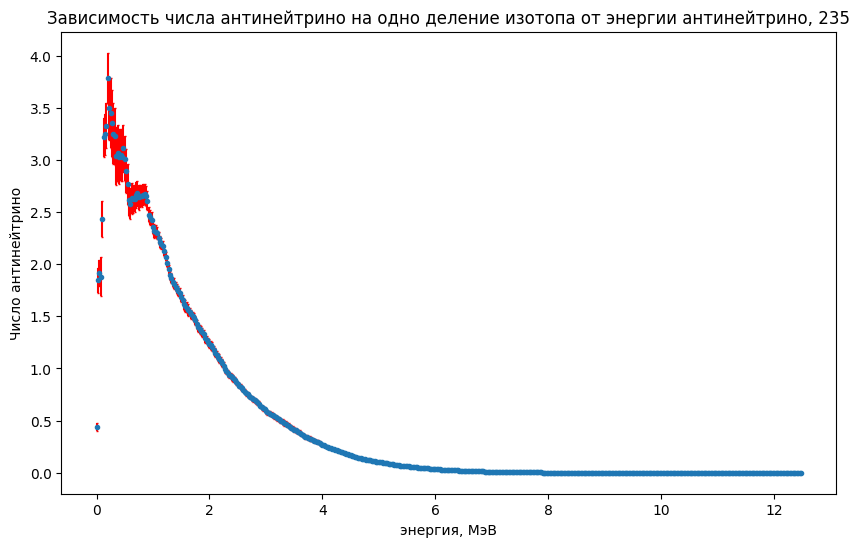

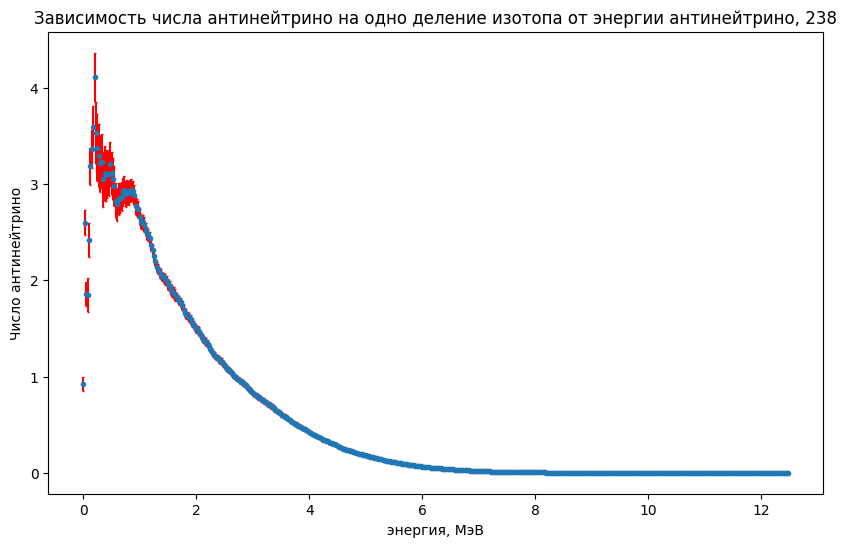

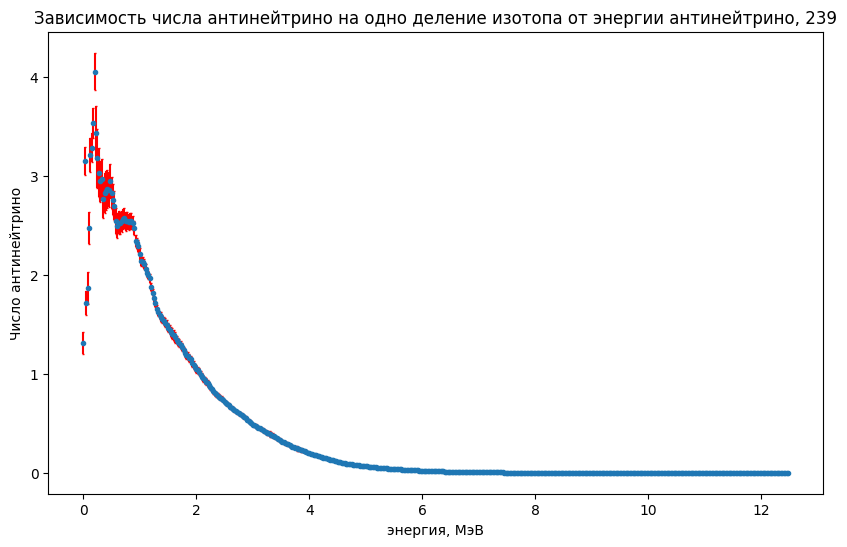

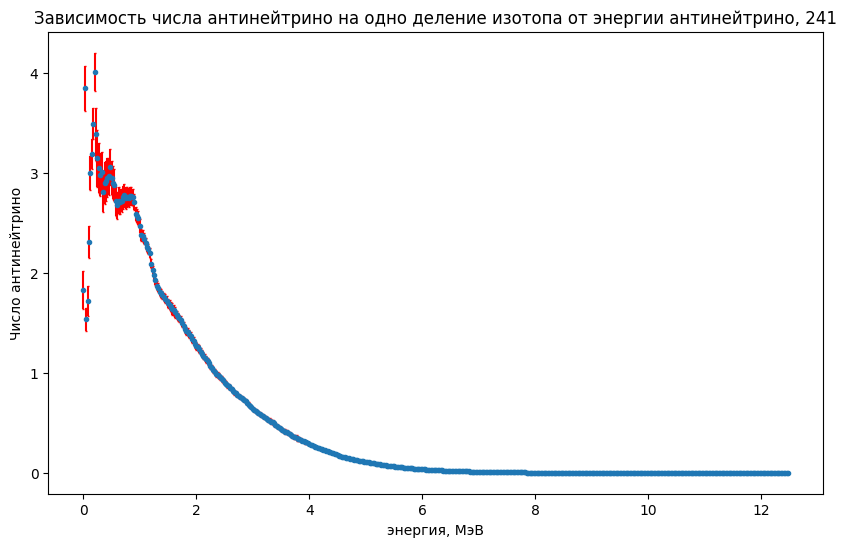

In [30]:
file_name = "BESTIOLE_amp_Fallot_Spectra.root"
file = uproot.open(file_name)
for key in file.keys():
    if "Best" in key:
        x = file[key].axis().edges()[:-1]
        y = file[key].values()
        err = file[key].errors()
        plt.figure(figsize=(10, 6))
        plt.errorbar(x, y, err, ecolor="r", fmt='.', capsize=1)
        plt.title(f"Зависимость числа антинейтрино на одно деление изотопа от энергии антинейтрино, {key[-10:-7]}")
        plt.xlabel("энергия, МэВ")
        plt.ylabel("Число антинейтрино")
        plt.show()
    else:
        break

#### Функции

In [2]:
def binary_search(list, key): # бинарный поиск
    low = 0
    high = len(list) - 1

    while low <= high:
        mid = (low + high) // 2
        midVal = list[mid]
        if midVal == key:
            return mid
        if midVal > key:
            high = mid - 1
        else:
            low = mid + 1
    return mid


def linear_interpolation(energy, x,  y): # линейная интерполяция
    ind = binary_search(x, energy)
    if energy > x[ind]:
        ind += 1
    k = (y[ind] - y[ind - 1]) / (x[ind] - x[ind - 1])
    b = y[ind] - k * x[ind]
    return k * energy + b

#### Классы

In [26]:
class Tablet():
    
    file_name = "BESTIOLE_amp_Fallot_Spectra.root"
    file = uproot.open(file_name)
    spectres = []
    sort = "Best" # выбор модели
    for key in file.keys():
        if sort in key:
            spectres.append((file[key].axis().edges()[:-1], file[key].values()))
    

    def __init__(self, coord, fuel_compos):
        self.t_coord = coord[:] # координаты таблетки
        self.fuel_compos = fuel_compos # изотопный состав

    
    def get_flux_in_point(self, coord, energy):
        area = 4 * np.pi * sum([(coord[i] - self.t_coord[i]) ** 2 for i in range(len(coord))])
        s = [linear_interpolation(energy, self.spectres[i][0], self.spectres[i][1]) * self.fuel_compos[i] for i in range(len(self.spectres))]
        return sum(s) / area


class Reactor():

    def __init__(self, tablets):
        self.tablets = [Tablet(tablet[0], tablet[1]) for tablet in tablets]

    
    def add_tablet(self, coord, fuel_compos):
        self.tablets.append(Tablet(coord, fuel_compos))
        
    
    def flux(self, coord, energy): # поток
        result_flux = sum([tablet.get_flux_in_point(coord, energy) for tablet in self.tablets])
        return result_flux

    
    def show(self): # красота
        x = [el.t_coord[0] for el in self.tablets]
        y = [el.t_coord[1] for el in self.tablets]
        z = [el.t_coord[2] for el in self.tablets]
        fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers')])
        fig.show()

#### Пример работы программы

In [27]:
tablets = [
    [(1.49923, -1.01127, -0.739099), (18, 4, 9, 19)],
    [(0.732916, 0.120131, 0.81584), (15, 13, 6, 16)],
    [(0.0590163, -0.994283, -0.0831989), (7, 4, 4, 0)],
    [(-0.499382, -0.917553, 1.50864), (11, 17, 13, 9)],
    [(0.181885, -0.953146, -0.691813), (2, 1, 12, 14)],
    [(0.411393, 0.641655, -1.36144), (13, 2, 2, 10)],
    [(-0.87666, -0.633269, -1.41721), (2, 10, 1, 5)],
    [(1.17487, -0.818646, -0.231725), (2, 8, 13, 3)],
    [(-0.177537, -1.36399, -0.641592), (10, 3, 10, 14)],
    [(-0.402034, -1.01757, -0.135637), (12, 13, 13, 9)]
]
reactor = Reactor(tablets)

coord = (20, 10, -15) # координаты заданы в метрах
energy = 0.5 # энергия задана в МэВ
flux = reactor.flux(coord, energy)
print(f"Поток антинейтрино в точке {coord}: {flux} 1 / (м2 * c)")

Поток антинейтрино в точке (20, 10, -15): 0.11402032010788166 1 / (м2 * c)


#### Скорость счёта детектора

In [29]:
j = reactor.flux(coord, energy)
delta = 1.293 # разность масс протона и нейтрона
m_e = 0.51099895000 # в мэвах
E_e = energy - delta
sigma = abs(1e-47 * np.sqrt(E_e ** 2 - m_e ** 2) * E_e * energy ** (-0.07056 + 0.02018 * np.log(energy) - 0.001593 * (np.log(energy) ** 3)))  # в метрах квадратных
d = j * sigma
print(f"Скорость счёта детектора по реакции обратного бета-распада: {d} 1/c")

-0.7929999999999999
Скорость счёта детектора по реакции обратного бета-распада: -5.8118062102971034e-49 1/c


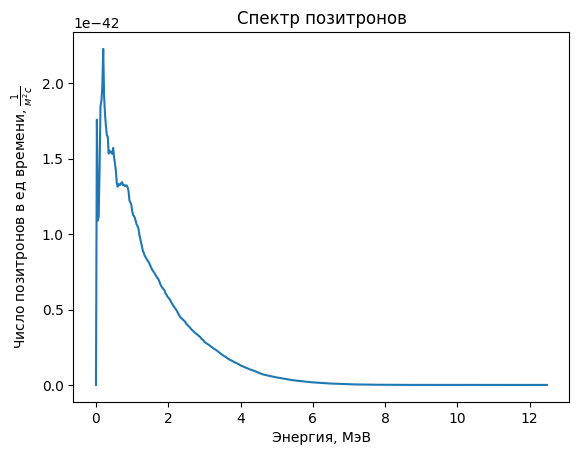

In [36]:
y = []
delta = 1.293 # разность масс протона и нейтрона
m_e = 0.51099895000 # в мэвах
E_e = energy - delta
for energy in x:
    j = reactor.flux(coord, energy)
    y.append(abs(1e-43 * np.sqrt(E_e ** 2 - m_e ** 2) * E_e * energy ** (-0.07056 + 0.02018 * np.log(energy) - 0.001593 * (np.log(energy) ** 3))) * j)

plt.title("Спектр позитронов")
plt.plot(x, y)
plt.xlabel("Энергия, МэВ")
plt.ylabel("Число позитронов в ед времени, $\\frac{1}{м^2 c}$")
plt.show()


In [ ]:
reactor.show()